In [1]:
# Import functions 
import sys
sys.path.insert(0, '..')
from racecar_utils import *   

ROS node started successfully


# Line Following

<p style='font-size:1.75rem;line-height:1.5'>
    Today, we will create an algorithm for the racecar to detect and follow a colored line. We will have several different tape colors for the car to select from. Each path will lead us on a different path adventure!
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>    
    Depending on the color, the racecar may take a shorter or longer path to its final destination. 
    </p>

## Step 1: Fix the Camera Offset

<p style='font-size:1.75rem;line-height:1.5'>
    The camera is slightly shifted horizontally (x-axis). 
    <br> Update <code>SCREEN_CENTER</code> to re-set the center pixel location of your output image.
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    The function below draws a circle at <code>SCREEN_CENTER</code>. 
    <br> How to find the correct value:
    <ol style='font-size:1.75rem;line-height:1.5'>
        <li>Place an object directly in front of your camera at where you think center is.</li>
        <li>Run the two cell blocks below to test your <code>SCREEN_CENTER</code> value. </li>
        <li>Your drawn circle should be matched to the center of the object in the outputted image. </li>
    </ol>
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    Getting the correct <code>SCREEN_CENTER</code> value here will help you later in the the <code>get_angle</code> function.
    </p>

In [2]:
SCREEN_CENTER = 325.0     # pixel x-axis, camera is right-shifted

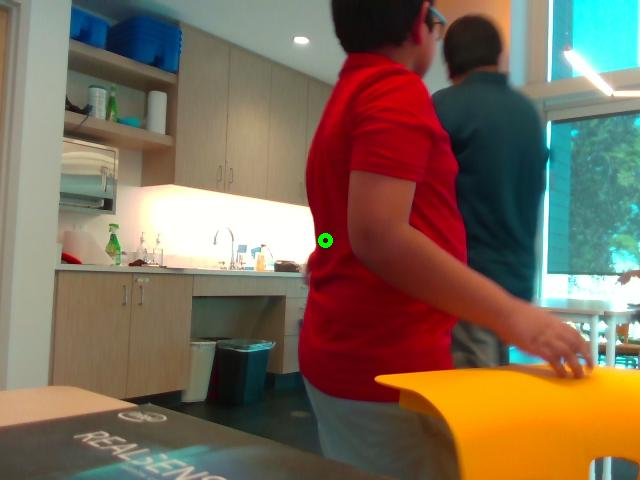

KeyboardInterrupt: 

In [3]:
# mark location of SCREEN_CENTER (x-axis)
def identify_center(color_img):
    if SCREEN_CENTER < 0 or SCREEN_CENTER > color_img.shape[1]:
        print('SCREEN_CENTER out of bounds! Your image is: {}'.format(color_img.shape[:2]))
    cv2.circle(color_img, (int(SCREEN_CENTER), color_img.shape[0]//2), 5, (0,255,0), 3)
    return color_img

# display image
show_video(identify_center)

## Step 2: Crop Image

<p style='font-size:1.75rem;line-height:1.5'>
    It is intuitive for us humans to trace the closest part of the line (the part under our feet) as we walk. However, the car sees a long line ahead of itself and doesn't know which part of the line to follow. We want to limit what the car sees/follows by limiting its field of view.
      </p>

<p style='font-size:1.75rem;line-height:1.5'>
    Modify <code>TOPLEFT_COORD</code> and <code>BOTTOMRIGHT_COORD</code> to crop the image below. The function draws a black rectangle over the top half of the image, showing only the part of the line that is closest to the car.
    </p>

In [3]:
TOPLEFT_COORD = (0, 350)
BOTTOMRIGHT_COORD = (639, 0)

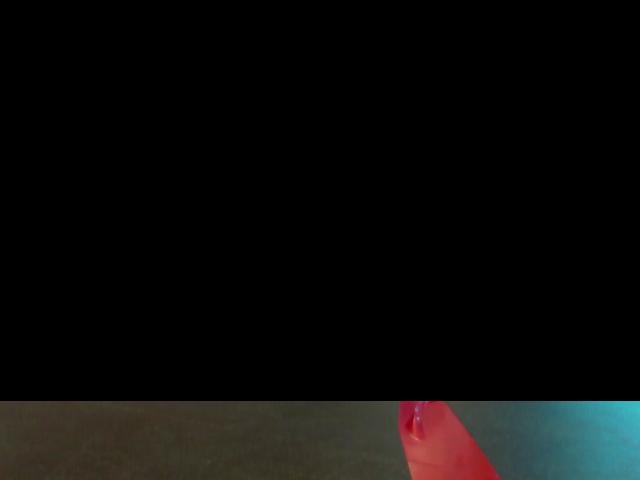

KeyboardInterrupt: 

In [4]:
#draws rectangle over frame to crop
def crop(img):
    cv2.rectangle(img, TOPLEFT_COORD, BOTTOMRIGHT_COORD, (0, 0, 0), -1)
    cv2.rectangle(img, (0, 400), (639, 0), (0, 0, 0), -1)
    return img

show_video(crop)

## Step 3: Find HSV Range of the Line

<p style='font-size:1.75rem;line-height:1.5'>
    Set the HSV lower and upper bounds to detect the line!
    <ol style='font-size:1.75rem;line-height:1.5'>
        <li>Use <code>hsv_select(&lt;seconds&gt;)</code> to mask for the cone!</li>
        <li>Update <code>HSV_LOWER</code> and <code>HSV_UPPER</code>!</li>
    </ol>
    </p>

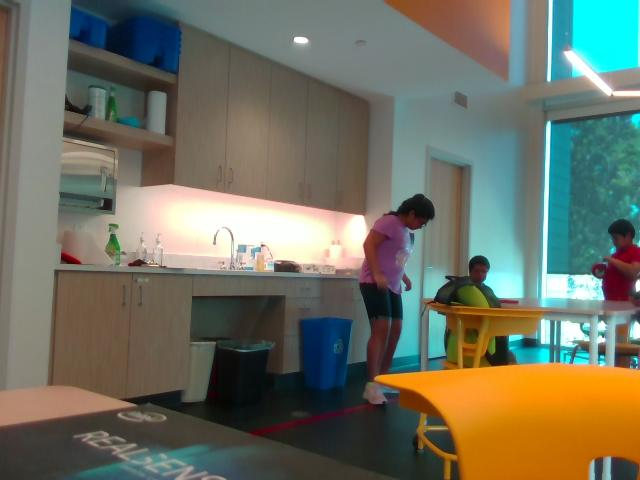

IntRangeSlider(value=(0, 179), description='Hue:', layout=Layout(width='100%'), max=179)

IntRangeSlider(value=(0, 255), description='Saturation:', layout=Layout(width='100%'), max=255)

IntRangeSlider(value=(0, 255), description='Value:', layout=Layout(width='100%'), max=255)

In [6]:
VIDEO_TIME = 60
hsv_select_live(VIDEO_TIME) # default: 10 sec

In [5]:
HSV_LOWER = np.array([153, 63, 56])
HSV_UPPER = np.array([179, 255, 255])

## Step 4: <code>get_angle</code>

<p style='font-size:1.75rem;line-height:1.5'>
    Now that we have the point we want to follow, we have to <b>determine what angle to turn the car</b> in order to get to that point.
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    <code>get_angle</code> returns the turn angle of the car. We will determine whether to turn left or right, and how much to turn, depending on the location of the cone in our image. When the cone is at the center of the image, the car and cone are aligned. 
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    This function is similar to the one we wrote for Cone Following, but NOT exactly. 
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li>The center of the cone is found at <code>contour_center</code></li>
        <li>Calculate the offset error: 
            <br><code>error = contour_center - float(SCREEN_CENTER)</code></li>
        <li>Calculate the ratio that the cone is away from the center of the screen: 
            <br><code>ratio = error / SCREEN_CENTER</code></li>
        <li>Multiply <code>ratio</code> by the <code>max_angle</code> to find the return angle. </li>
    </ul>
    </p>

In [6]:
TURN_FACTOR = 0.10        # max turn angle (in degrees)
DRIVE_SPEED = 0.0340       # car speed      

In [7]:
def get_angle(contour_center):
    max_angle = -abs(TURN_FACTOR) 
    
    # TASK #1: Calculate the offset error
    error = contour_center - float(SCREEN_CENTER)

    # TASK #2: Calculate the ratio
    ratio = error/SCREEN_CENTER

    # TASK #3: Calculate the turn angle
    angle = ratio*max_angle 

    # TASK #4: Return the turn angle
    return angle

## Step 5: <code>get_contour_center</code>

<p style='font-size:1.75rem;line-height:1.5'>
    <code>get_contour_center</code> returns the center of the largest contour (if contours exist). Else, the function returns None. 
    </p>
    
<p style='font-size:1.75rem;line-height:1.5'>
    Run the cell block below.
    </p>

In [8]:
EXIST_SIZE = 200

In [9]:
def get_contour_center(contours):
    greatest_contour = None
    if len(contours) > 0:
        greatest_contour = max(contours, key = cv2.contourArea) # get largest contour
        if cv2.contourArea(greatest_contour) < EXIST_SIZE:
            greatest_contour = None 
    M = None
    if greatest_contour is not None:
        M = cv2.moments(greatest_contour)
    return M

In [10]:
def find_contours(img):
    # TASK #1: Convert the img to from rgb to hsv.
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # TASK #2: Mask the image using HSV_LOWER and HSV_UPPER. Save as 'mask'.
    mask = cv2.inRange(img_hsv, HSV_LOWER, HSV_UPPER)
    
    # TASK #3: Find the contours in the image. Save as 'contours'.
    contours = cv2.findContours(mask, 3, 2)[0]
    #print(contours)
    return contours, mask

In [11]:
def check_contours_exist(contours):
    greatest_contour = None
    
    # TASK #1: If the contours list is empty, return (False, greatest_contour)
    if contours == [] or contours is None:
        print('No contours')
        return (False, greatest_contour)
    
    greatest_contour = max(contours, key = cv2.contourArea) # get largest contour
    
    # TASK #2: If the contour area of the greatest contour is smaller than 'EXIST_SIZE', return (False, greatest_contour)
    area = cv2.contourArea(greatest_contour)
    if area < EXIST_SIZE:
        print('Too small: {}'.format(area))
        return (False, greatest_contour)
    
    return (True, greatest_contour)

## Step 6: <code>line_following</code>

<p style='font-size:1.75rem;line-height:1.5'>
    Now, let us write the <code>line_following</code> function below: 
    </p>

In [12]:
TEST_TIME = 1000

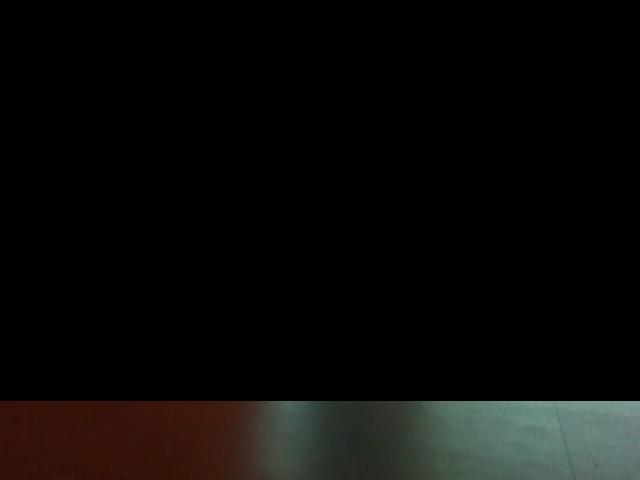

size: 309.0 center: 412
size: 323.0 center: 410
size: 504.5 center: 411
size: 583.5 center: 412
size: 705.0 center: 413
size: 993.0 center: 417
size: 1796.5 center: 428
size: 4023.0 center: 444
size: 4424.0 center: 443
size: 4709.0 center: 442
size: 4230.0 center: 444
size: 3909.0 center: 444
size: 3848.5 center: 444
size: 3996.0 center: 444
size: 3966.0 center: 445
size: 3950.0 center: 445
size: 3980.5 center: 444
size: 4013.0 center: 445
size: 3961.0 center: 444
size: 3986.5 center: 444
size: 4012.5 center: 444
size: 3825.0 center: 445
size: 3982.5 center: 443
size: 3922.5 center: 444
size: 4070.5 center: 443
size: 3901.0 center: 444
size: 3871.0 center: 445
size: 3977.0 center: 444
size: 3984.0 center: 443
size: 3974.5 center: 445
size: 3952.0 center: 444
size: 3956.0 center: 444
size: 3834.5 center: 444
size: 3028.5 center: 441
size: 2843.5 center: 435
size: 3526.5 center: 436
size: 4211.0 center: 426
size: 4137.5 center: 419
size: 4638.5 center: 411
size: 5175.5 center: 404
size: 

size: 5725.0 center: 527
size: 5749.5 center: 527
size: 5753.0 center: 527
size: 5718.5 center: 528
size: 5729.5 center: 527
size: 5720.0 center: 527
size: 5798.0 center: 527
size: 5745.5 center: 527
size: 5710.0 center: 528
size: 5697.5 center: 527
size: 5724.0 center: 527
size: 5725.5 center: 527
size: 5718.0 center: 527
size: 5743.5 center: 527
size: 5747.0 center: 528
size: 5316.0 center: 539
size: 3285.5 center: 614
No contours
No contours
Too small: 3.0
Too small: 1.0
No contours
No contours
No contours
No contours
No contours
No contours
No contours
size: 507.5 center: 629
size: 1340.5 center: 564
size: 940.5 center: 416
size: 430.0 center: 226
size: 788.5 center: 95
Too small: 3.0
No contours
Too small: 10.0
Too small: 86.0
Too small: 92.5
Too small: 106.0
Too small: 84.0
Too small: 5.5
Too small: 75.5
Too small: 9.0
No contours
No contours
Too small: 51.0
size: 1723.5 center: 65
size: 1931.5 center: 324
size: 3938.5 center: 368
size: 3932.5 center: 339
size: 3881.0 center: 350

size: 3787.5 center: 431
size: 3956.5 center: 428
size: 3968.0 center: 420
size: 4725.0 center: 412
size: 4185.0 center: 412
size: 4694.5 center: 408
size: 4883.0 center: 413
size: 5044.5 center: 424
size: 3507.5 center: 441
size: 5222.0 center: 465
size: 5077.0 center: 484
size: 2741.5 center: 483
size: 681.0 center: 474
No contours
No contours
Too small: 1.0
Too small: 9.5
Too small: 126.0
Too small: 192.0
Too small: 140.5
size: 1235.5 center: 168
size: 1833.0 center: 153
size: 3596.5 center: 110
size: 4798.0 center: 97
size: 4703.0 center: 97
size: 4511.0 center: 103
size: 4435.5 center: 109
size: 4188.0 center: 117
size: 4369.5 center: 130
size: 4261.5 center: 143
size: 4278.5 center: 166
size: 4859.5 center: 197
size: 5585.5 center: 231
size: 4635.0 center: 268
size: 4052.5 center: 311
size: 3392.0 center: 366
size: 4156.0 center: 427
size: 5417.5 center: 461
size: 5844.0 center: 481
size: 5511.5 center: 490
size: 4515.5 center: 491
size: 4274.0 center: 482
size: 4922.5 center: 45

KeyboardInterrupt: 

In [13]:
def line_follower(drive_function):
    def line_follow(color_img, depth_img):
        speed, angle = [0.0, 0.0]
   
        # run student helper functions
        contours, mask = find_contours(crop(color_img))
        contours_exist, greatest_contour = check_contours_exist(contours)
        if (contours_exist is True) and (cv2.contourArea(greatest_contour) > EXIST_SIZE):
            M = get_contour_center(contours)
            if M is not None:
                #print(M['m00'])
                if M['m00'] > EXIST_SIZE:
                    x, y = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])
                    contour_center = x
                    print(f'size: {M["m00"]} center: {contour_center}')
                    speed = DRIVE_SPEED
    #                 speed = 0.0
                    angle = get_angle(contour_center)
                    #print(angle)
                    #contour_area = cv2.contourArea(greatest_contour)
                    cv2.drawContours(color_img, [greatest_contour], -1, (0, 255, 0), 2)

#                     cv2.drawContours(color_img, contours, -1, (255, 0, 0), 2)
                    drive_function(speed, angle)
            #else:
            #    drive_function(0.0, 0.0)
            
        #return cropped image
        return color_img
   
    show_video(line_follow, TEST_TIME, True, True)

withDriving(line_follower)

## Step 7: Parameter Tuning

<p style='font-size:1.75rem;line-height:1.5'>
    Tune the following parameters to improve your line follower!
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li><code>SCREEN_CENTER</code>: to adjust for screen center offset</li>
        <li><code>TOPLEFT_COORD</code> and <code>BOTTOMRIGHT_COORD</code>: to adjust the crop size view area</li>
        <li><code>HSV_LOWER</code> and <code>HSV_UPPER</code>: to adjust the threshold color</li>
        <li><code>TURN_FACTOR</code>: for the turn intensity of the car</li>
        <li><code>DRIVE_SPEED</code>: for the speed of the car</li>
    </ul>
    </p>

# Line Following Competition!!!

<p style='font-size:1.75rem;line-height:1.5'>
    We have prepared a race track, where we will compete against other teams to finish the course in the shortest time AND follow the line with most elegance.
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    Each judge will rank teams (<code>1</code> - <code>10</code>) based on: time, speed, accuracy, and elegance.
    </p>
    

<p style='font-size:1.75rem;line-height:1.5'>
    The final score is:
    </p>
    
```python
score = judges_total_score - (time / 2)
```